# Polynômes de chaos : application au cas de la poutre encastrée avec chaos par intégration - Solution

In [1]:
import openturns as ot
import openturns.viewer as otv

In [2]:
ot.__version__

'1.26'

In [3]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # En mètres
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴  # in cm^4
distributionI.setDescription(["I"])

myDistribution = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])
myDistribution

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 2.2, a = 2.8e+07, b = 4.8e+07)"
1,F,"ParametrizedDistribution(parameters = LogNormalMuSigma(mu = 30000, sigma = 9000, gamma = 15000))"
2,L,"Uniform(a = 250, b = 260)"
3,I,"Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)"


In [4]:
dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L**3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Créer le polynôme

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [5]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [distributionE, distributionF, distributionL, distributionI]
)

In [6]:
totalDegree = 2
enumerateFunction = multivariateBasis.getEnumerateFunction()
maximumBasisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=15

In [7]:
distributionStandard = multivariateBasis.getMeasure()
distributionStandard

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 2.2, a = -1, b = 1)"
1,X0,"LogNormal(muLog = 9.46206, sigmaLog = 0.554513, gamma = 0)"
2,L,"Uniform(a = -1, b = 1)"
3,I,"Beta(alpha = 2.5, beta = 1.5, a = -1, b = 1)"


In [8]:
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(myDistribution, marginalSize)
inputSample, weights = experiment.generateWithWeights()
inputSample.getSize()

256

In [9]:
outputSample = g(inputSample)

In [10]:
projectionStrategy = ot.IntegrationStrategy(experiment)

chaosAlgo = ot.FunctionalChaosAlgorithm(
    inputSample,
    weights,
    outputSample,
    myDistribution,
    adaptiveStrategy,
    projectionStrategy,
)
chaosAlgo.run()

result = chaosAlgo.getResult()
result

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62464
1,"[1,0,0,0]",-1.552065
2,"[0,1,0,0]",3.787392
3,"[0,0,1,0]",0.4286234
4,"[0,0,0,1]",-0.9992086
5,"[2,0,0,0]",0.2021305
6,"[1,1,0,0]",-0.4656196
7,"[1,0,1,0]",-0.0526947
8,"[1,0,0,1]",0.1228421
9,"[0,2,0,0]",-8.595609e-15


In [11]:
metamodel = result.getMetaModel()

## Validate the metamodel

In [12]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [13]:
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))

Compute the $Q^2$ predictivity coefficient

In [14]:
Q2 = val.computeR2Score()[0]
Q2

0.9995427446350182

Plot the observed versus the predicted outputs.

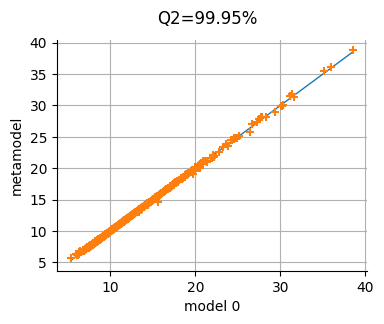

In [15]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les coefficients sont relativement bien estimés puisque le Q2 est excellent (parfait ?), malgré un nombre de points relativement réduit dans le plan d'expériences (256 points).

## Partie 2 : ouvrons la boîte


In [16]:
totalDegree = 2
enumerateFunction = multivariateBasis.getEnumerateFunction()
basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
basisSize

15

In [17]:
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(myDistribution, marginalSize)
inputSample, weights = experiment.generateWithWeights()
outputSample = g(inputSample)
sampleSize = inputSample.getSize()
sampleSize

256

In [18]:
distributionStandard = multivariateBasis.getMeasure()
transformation = ot.DistributionTransformation(myDistribution, distributionStandard)
standardSample = transformation(inputSample)
inverseTransformation = transformation.inverse()

In [19]:
outputDimension = 1
coefficients = ot.Sample(basisSize, outputDimension)
functionalBasis = []
for k in range(basisSize):
    basisFunction = multivariateBasis.build(k)
    functionalBasis.append(basisFunction)
    basisValue = basisFunction(standardSample)
    integrandValue = ot.Point(
        [basisValue[j, 0] * outputSample[j, 0] for j in range(sampleSize)]
    )
    coefficients[k, 0] = integrandValue.dot(weights)
coefficients[:10]

,v0
0,12.62464
1,-1.552065
2,3.787392
3,0.4286234
4,-0.9992086
5,0.2021305
6,-0.4656196
7,-0.0526947
8,0.1228421
9,-8.664131e-15


In [20]:
indices = range(basisSize)
pceResult = ot.FunctionalChaosResult(
    inputSample,
    outputSample,
    myDistribution,
    transformation,
    inverseTransformation,
    multivariateBasis,
    indices,
    coefficients,
    functionalBasis,
)
pceResult

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62464
1,"[1,0,0,0]",-1.552065
2,"[0,1,0,0]",3.787392
3,"[0,0,1,0]",0.4286234
4,"[0,0,0,1]",-0.9992086
5,"[2,0,0,0]",0.2021305
6,"[1,1,0,0]",-0.4656196
7,"[1,0,1,0]",-0.0526947
8,"[1,0,0,1]",0.1228421
9,"[0,2,0,0]",-8.664131e-15


In [21]:
metamodel = pceResult.getMetaModel()

sampleSizeValidation = 10000
inputTest = myDistribution.getSample(sampleSizeValidation)
outputTest = g(inputTest)

val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
q2Score = val.computeR2Score()[0]
q2Score

0.9995991362612449

## Solution de l'exercice 1 : changer de méthode de quadrature


In [22]:
def ComputeFullIntegrationChaos(
    g_function, multivariateBasis, totalDegree, myDistribution, experiment
):
    """
    Create a full polynomial chaos with integration based on an experiment.

    * Uses the enumeration rule from multivariateBasis.
    * Uses IntegrationStrategy to compute the coefficients using
    integration.
    * Uses FixedStrategy to keep all coefficients.

    When the number of input variables
    or the required marginal degree is large, the design of experiments is
    very large.

    Parameters
    ----------
    g_function : ot.Function
        The function to create the metamodel from.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The total polynomial degree.
        The total degree is the sum of the marginal degrees.
    myDistribution : ot.Distribution
        The distribution of the input random vector
    experiment : ot.WeightedExperiment
        The design of experiment for quadrature

    Returns
    -------
    result : ot.FunctionalChaosAlgorithm
        The polynomial chaos algorithm
    """
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    maximumBasisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
    projectionStrategy = ot.IntegrationStrategy(experiment)
    inputSample, weights = experiment.generateWithWeights()
    outputSample = g_function(inputSample)
    chaosAlgo = ot.FunctionalChaosAlgorithm(
        inputSample,
        weights,
        outputSample,
        myDistribution,
        adaptiveStrategy,
        projectionStrategy,
    )
    return chaosAlgo

In [23]:
def computeChaosAndValidate(
    totalDegree,
    g_function,
    multivariateBasis,
    myDistribution,
    experiment,
    sampleSizeValidation,
):
    """
    Create a full polynomial chaos with integration and return the Q2.

    Uses a Monte-Carlo sample to validate the metamodel.

    Parameters
    ----------
    totalDegree : int
        The total polynomial degree.
        The total degree is the sum of the marginal degrees.
    g_function : ot.Function
        The function to create the metamodel from.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    myDistribution : ot.Distribution
        The distribution of the input random vector
    experiment : ot.WeightedExperiment
        The design of experiment for quadrature
    sampleSizeValidation : int
        The sample size used to validate the metamodel

    Returns
    -------
    q2Score : float
        The Q2 score.
    """
    chaosAlgo = ComputeFullIntegrationChaos(
        g_function, multivariateBasis, totalDegree, myDistribution, experiment
    )
    chaosAlgo.run()
    result = chaosAlgo.getResult()
    metamodel = result.getMetaModel()

    inputTest = myDistribution.getSample(sampleSizeValidation)
    outputTest = g(inputTest)

    val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
    q2Score = val.computeR2Score()[0]
    return q2Score

In [24]:
totalDegree = 5
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(myDistribution, marginalSize)
sampleSize = experiment.generate().getSize()
print("Sample size = ", sampleSize)
sampleSizeValidation = 1000
q2Score = computeChaosAndValidate(
    totalDegree, g, multivariateBasis, myDistribution, experiment, sampleSizeValidation
)
print("Q2 = %.2f%%" % (q2Score * 100))

Sample size =  256
Q2 = 100.00%


In [25]:
totalDegree = 2
size = 10000
for i in range(10):
    experiment = ot.MonteCarloExperiment(myDistribution, size)
    sampleSize = experiment.generate().getSize()
    sampleSizeValidation = 1000
    q2Score = computeChaosAndValidate(
        totalDegree,
        g,
        multivariateBasis,
        myDistribution,
        experiment,
        sampleSizeValidation,
    )
    print("Sample size = ", sampleSize, "Q2=%.2f%%" % (q2Score * 100))

Sample size =  10000 Q2=98.42%
Sample size =  10000 Q2=93.04%
Sample size =  10000 Q2=99.04%
Sample size =  10000 Q2=96.77%
Sample size =  10000 Q2=98.17%
Sample size =  10000 Q2=98.06%
Sample size =  10000 Q2=97.64%
Sample size =  10000 Q2=96.65%
Sample size =  10000 Q2=97.80%
Sample size =  10000 Q2=98.10%


In [26]:
totalDegree = 3
size = 10000
sequence = ot.SobolSequence()
experiment = ot.LowDiscrepancyExperiment(sequence, myDistribution, size)
sampleSize = experiment.generate().getSize()
print("Sample size = ", sampleSize)
sampleSizeValidation = 1000
q2Score = computeChaosAndValidate(
    totalDegree, g, multivariateBasis, myDistribution, experiment, sampleSizeValidation
)
print("Q2=%.2f%%" % (q2Score * 100))

Sample size =  10000
Q2=98.92%


## Solution de l'exercice 2

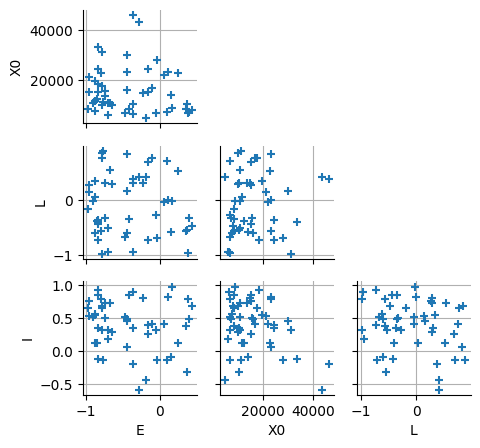

In [27]:
size = 50
experiment = ot.MonteCarloExperiment(distributionStandard, size)
sample = experiment.generate()
graph = ot.VisualTest.DrawPairs(sample)
view = otv.View(graph, figure_kw={"figsize": (5.0, 5.0)})

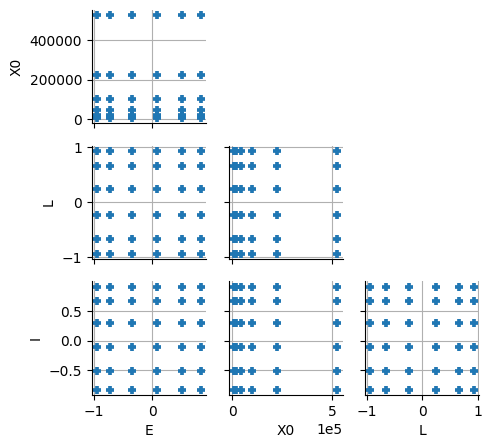

In [28]:
marginalSize = [6] * dim_input
experiment = ot.GaussProductExperiment(distributionStandard, marginalSize)
sample = experiment.generate()
graph = ot.VisualTest.DrawPairs(sample)
view = otv.View(graph, figure_kw={"figsize": (5.0, 5.0)})

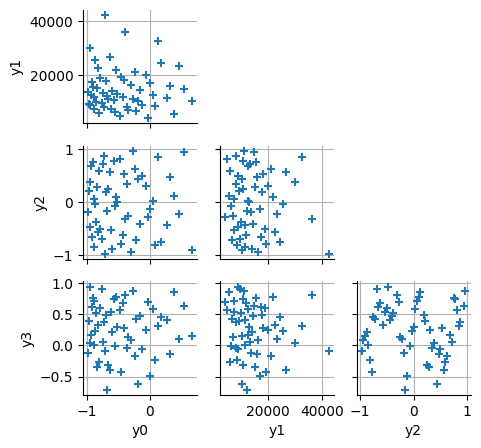

In [29]:
size = 56
sequence = ot.SobolSequence()
experiment = ot.LowDiscrepancyExperiment(sequence, distributionStandard, size, True)
sample = experiment.generate()
graph = ot.VisualTest.DrawPairs(sample)
view = otv.View(graph, figure_kw={"figsize": (5.0, 5.0)})

## Solution de l'exercice 3 : quadrature de Smolyak

In [30]:
distributionCollection = myDistribution.getDistributionCollection()
experimentList = [
    ot.GaussProductExperiment(distributionCollection[i]) for i in range(dim_input)
]
level = 3
experiment = ot.SmolyakExperiment(experimentList, level)
sampleSize = experiment.generate().getSize()
print("Sample size = ", sampleSize)
sampleSizeValidation = 1000
q2Score = computeChaosAndValidate(
    totalDegree, g, multivariateBasis, myDistribution, experiment, sampleSizeValidation
)
print("Q2=%.2f%%" % (q2Score * 100))

Sample size =  44
Q2=99.87%


## Solution de l'exercice 4 : on ouvre la boîte de l'estimation des coefficients par intégration

In [31]:
def computeIntegrationFullPCECustom(
    g_function, multivariateBasis, totalDegree, myDistribution, experiment
):
    """
    Create a full polynomial chaos with integration based on an experiment.

    * Uses the enumeration rule from multivariateBasis.
    * Uses IntegrationStrategy to compute the coefficients using
    integration.
    * Uses FixedStrategy to keep all coefficients.

    When the number of input variables
    or the required marginal degree is large, the design of experiments is
    very large.

    Parameters
    ----------
    g_function : ot.Function
        The function to create the metamodel from.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The total polynomial degree.
        The total degree is the sum of the marginal degrees.
    myDistribution : ot.Distribution
        The distribution of the input random vector
    experiment : ot.WeightedExperiment
        The design of experiment for quadrature

    Returns
    -------
    pceResult : ot.FunctionalChaosResult
        The polynomial chaos expansion
    """
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
    inputSample, weights = experiment.generateWithWeights()
    outputSample = g_function(inputSample)
    sampleSize = inputSample.getSize()
    distributionStandard = multivariateBasis.getMeasure()
    transformation = ot.DistributionTransformation(myDistribution, distributionStandard)
    standardSample = transformation(inputSample)
    inverseTransformation = transformation.inverse()
    outputDimension = 1
    coefficients = ot.Sample(basisSize, outputDimension)
    functionalBasis = []
    for k in range(basisSize):
        basisFunction = multivariateBasis.build(k)
        functionalBasis.append(basisFunction)
        basisValue = basisFunction(standardSample)
        integrandValue = ot.Point(
            [basisValue[j, 0] * outputSample[j, 0] for j in range(sampleSize)]
        )
        coefficients[k, 0] = integrandValue.dot(weights)
    indices = range(basisSize)
    pceResult = ot.FunctionalChaosResult(
        inputSample,
        outputSample,
        myDistribution,
        transformation,
        inverseTransformation,
        multivariateBasis,
        indices,
        coefficients,
        functionalBasis,
    )
    return pceResult

In [32]:
def pce2SparsePce(pceResult, activeIndices):
    """
    Create a sparse PCE from a full PCE

    Parameters
    ----------
    pceResult : ot.FunctionalChaosResult
        The full PCE
    activeIndices : list(int)
        The list of active indices in the sparse PCE

    Returns
    -------
    sparsePceResult : ot.FunctionalChaosResult
        The full PCE
    """
    # Extract the fields
    coefficients = pceResult.getCoefficients()
    numberOfCoefficients = coefficients.getSize()
    inputSample = pceResult.getInputSample()
    outputSample = pceResult.getOutputSample()
    distribution = pceResult.getDistribution()
    transformation = pceResult.getTransformation()
    inverseTransformation = pceResult.getInverseTransformation()
    multivariateBasis = pceResult.getOrthogonalBasis()
    functionalBasis = pceResult.getReducedBasis()

    #
    activeIndices = ot.Indices(activeIndices)
    activeIndices.check(numberOfCoefficients)

    # Select active components
    activeCoefficients = ot.Sample(0, 1)
    activeFunctionalBasis = []
    for k in activeIndices:
        activeCoefficients.add(coefficients[k])
        activeFunctionalBasis.append(functionalBasis[k])

    # Create the sparse PCE
    sparsePceResult = ot.FunctionalChaosResult(
        inputSample,
        outputSample,
        distribution,
        transformation,
        inverseTransformation,
        multivariateBasis,
        activeIndices,
        activeCoefficients,
        activeFunctionalBasis,
    )

    return sparsePceResult

In [33]:
def searchSparsePCEForward(fullPCEResult, inputTest, outputTest, verbose=True):
    """
    Search for a sparse PCE

    The algorithm initializes with a sparse PCE with the mean only.
    Then each candidate coefficients is evaluated with
    respect to its Q2 score.
    The candidate coefficient which enters into the basis is the
    one which best improves the score

    Parameters
    ----------
    fullPCEResult : ot.FunctionalChaosResult
        The full PCE
    inputTest : ot.Sample(sampleSize, inputDimension)
        The input test sample
    outputTest : ot.Sample(sampleSize, 1)
        The output test sample
    verbose : bool
        If True, then print intermediate messages

    Returns
    -------
    activeIndicesHistory : list(bool)
        The list of coefficients index as they enter the active basis.
    """
    activeIndicesHistory = []
    q2ScoreHistory = []
    # Initialize the sparse PCE
    coefficients = fullPCEResult.getCoefficients()
    numberOfCoefficients = coefficients.getSize()
    activationIndices = [0]
    activeIndicesHistory.append(0)
    newSparsePCEResult = pce2SparsePce(fullPCEResult, activationIndices)
    metamodel = newSparsePCEResult.getMetaModel()
    val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
    q2Score = val.computeR2Score()[0]
    q2ScoreHistory.append(q2Score)
    if verbose:
        print(f"Initial q2 = {q2Score:.4f}")
    # Loop over the candidate coefficients
    for step in range(numberOfCoefficients - 1):
        if verbose:
            print(f"Step {step}")
            print(f"activationIndices = {activationIndices}")
        # Search the coefficient which best improves the Q2 score
        bestIndex = None
        bestQ2Score = q2Score
        for k in range(1, numberOfCoefficients):
            if k not in activationIndices:
                newActivationIndices = activationIndices.copy()  # Copy
                newActivationIndices.append(k)
                newSparsePCEResult = pce2SparsePce(fullPCEResult, newActivationIndices)
                newMetamodel = newSparsePCEResult.getMetaModel()
                val = ot.MetaModelValidation(outputTest, newMetamodel(inputTest))
                newQ2Score = val.computeR2Score()[0]
                if verbose:
                    print(f"    k = {k}, q2 = {newQ2Score:.4f}")
                if newQ2Score > bestQ2Score:
                    bestQ2Score = newQ2Score
                    bestIndex = k

        if bestIndex is None:
            if verbose:
                print("    Cannot improve Q2 score")
            break
        else:
            if verbose:
                print(
                    f"    Best index = {bestIndex}, best Q2 score = {bestQ2Score:.4f}"
                )
            activationIndices.append(bestIndex)
            q2Score = bestQ2Score
            activeIndicesHistory.append(bestIndex)
            q2ScoreHistory.append(bestQ2Score)
    return activeIndicesHistory, q2ScoreHistory

In [34]:
totalDegree = 2
fullPCEResult = computeIntegrationFullPCECustom(
    g, multivariateBasis, totalDegree, myDistribution, experiment
)
fullPCEResult

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62454
1,"[1,0,0,0]",-1.551366
2,"[0,1,0,0]",3.785765
3,"[0,0,1,0]",0.4284426
4,"[0,0,0,1]",-0.998742
5,"[2,0,0,0]",0.1968299
6,"[1,1,0,0]",-0.4546846
7,"[1,0,1,0]",-0.0514752
8,"[1,0,0,1]",0.1197836
9,"[0,2,0,0]",-0.002185645


In [35]:
metamodel = fullPCEResult.getMetaModel()
sampleSizeValidation = 10000
inputTest = myDistribution.getSample(sampleSizeValidation)
outputTest = g(inputTest)

val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
q2Score = val.computeR2Score()[0]
q2Score

0.9996039713149467

In [36]:
coefficients = fullPCEResult.getCoefficients()
numberOfCoefficients = coefficients.getSize()
activeIndices = [0, 2, 1, 4, 6, 3, 11, 5, 10, 8, 14, 7, 13]
# Just keep 5 coefficients
sparsePCEResult = pce2SparsePce(fullPCEResult, activeIndices[:5])
sparsePCEResult

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62454
1,"[0,1,0,0]",3.785765
2,"[1,0,0,0]",-1.551366
3,"[0,0,0,1]",-0.998742
4,"[1,1,0,0]",-0.4546846


In [37]:
metamodel = sparsePCEResult.getMetaModel()
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
q2Score = val.computeR2Score()[0]
q2Score

0.980354060129472

In [38]:
activeIndicesHistory, q2ScoreHistory = searchSparsePCEForward(
    fullPCEResult, inputTest, outputTest, verbose=True
)
activeIndicesHistory

Initial q2 = -0.0001
Step 0
activationIndices = [0]
    k = 1, q2 = 0.1233
    k = 2, q2 = 0.7876
    k = 3, q2 = 0.0064
    k = 4, q2 = 0.0517
    k = 5, q2 = 0.0015
    k = 6, q2 = 0.0143
    k = 7, q2 = -0.0001
    k = 8, q2 = 0.0008
    k = 9, q2 = -0.0002
    k = 10, q2 = -0.0001
    k = 11, q2 = 0.0028
    k = 12, q2 = -0.0001
    k = 13, q2 = -0.0001
    k = 14, q2 = 0.0007
    Best index = 2, best Q2 score = 0.7876
Step 1
activationIndices = [0, 2]
    k = 1, q2 = 0.9158
    k = 3, q2 = 0.7968
    k = 4, q2 = 0.8401
    k = 5, q2 = 0.7900
    k = 6, q2 = 0.7985
    k = 7, q2 = 0.7877
    k = 8, q2 = 0.7888
    k = 9, q2 = 0.7876
    k = 10, q2 = 0.7883
    k = 11, q2 = 0.7924
    k = 12, q2 = 0.7876
    k = 13, q2 = 0.7875
    k = 14, q2 = 0.7882
    Best index = 1, best Q2 score = 0.9158
Step 2
activationIndices = [0, 2, 1]
    k = 3, q2 = 0.9254
    k = 4, q2 = 0.9694
    k = 5, q2 = 0.9181
    k = 6, q2 = 0.9265
    k = 7, q2 = 0.9158
    k = 8, q2 = 0.9168
    k = 9, q2 = 0

[0, 2, 1, 4, 6, 3, 11, 5, 10, 8, 14, 7, 13, 9]

In [39]:
q2ScoreHistory

[-0.0001228715089438559,
 0.7876004852366854,
 0.9157867074637578,
 0.9693729761546284,
 0.980354060129472,
 0.9901615124954527,
 0.9951700690640091,
 0.9973587770520911,
 0.9982176118611448,
 0.998988719208328,
 0.9993936094821465,
 0.9995424965344755,
 0.9996042946580145,
 0.9996049285893297]

In [40]:
coefficients = fullPCEResult.getCoefficients()
numberOfCoefficients = coefficients.getSize()
absoluteCoefficients = ot.Sample.BuildFromPoint(
    [abs(coefficients[k, 0]) for k in range(numberOfCoefficients)]
)
coefficientsOrdering = absoluteCoefficients.argsort(False)
coefficientsOrdering

[0,2,1,4,6,3,11,5,10,8,14,7,13,9,12]